In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
import os
import ants

from IPython.display import display
from numpy.lib.format import open_memmap
from skimage.util import montage

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.filters as fil

from skimage import exposure
from skimage.exposure import match_histograms
from skimage.filters.rank import median
from skimage.morphology import ball, disk
from skimage.filters import unsharp_mask, gaussian
from skimage.util import img_as_ubyte

from scipy import ndimage

datasets_dir = init.init('Preprocessing')

mask_path = "/user/lcorcos/home/MEGAsync/Ressources/Manual segmentation/Mask.nii.gz"
T1_path = "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101410/T1w/T1w_acpc_dc_restore.nii.gz"
T2_path = "/user/lcorcos/home/MEGAsync/Ressources/Manual segmentation/101410/T1w/T2w_acpc_dc_restore.nii.gz"



<br>**ATHENA - MRI Segmentation - Preprocessing**

Version              : 1.0
Notebook id          : Preprocessing
Run time             : Monday 08 August 2022, 17:26:13
Hostname             : eire (Linux)
Tensorflow log level : Info + Warning + Error (=0)
Datasets dir         : /user/lcorcos/home/Desktop/MRI_Project/Data/
Run dir              : ./run
Update keras cache   : False
numpy                : 1.22.3
sklearn              : 1.0.2
skimage              : 0.19.2
matplotlib           : 3.5.1
plotly               : 5.6.0
pandas               : 1.4.2
nibabel              : 3.2.2


#### **Manual mask process**

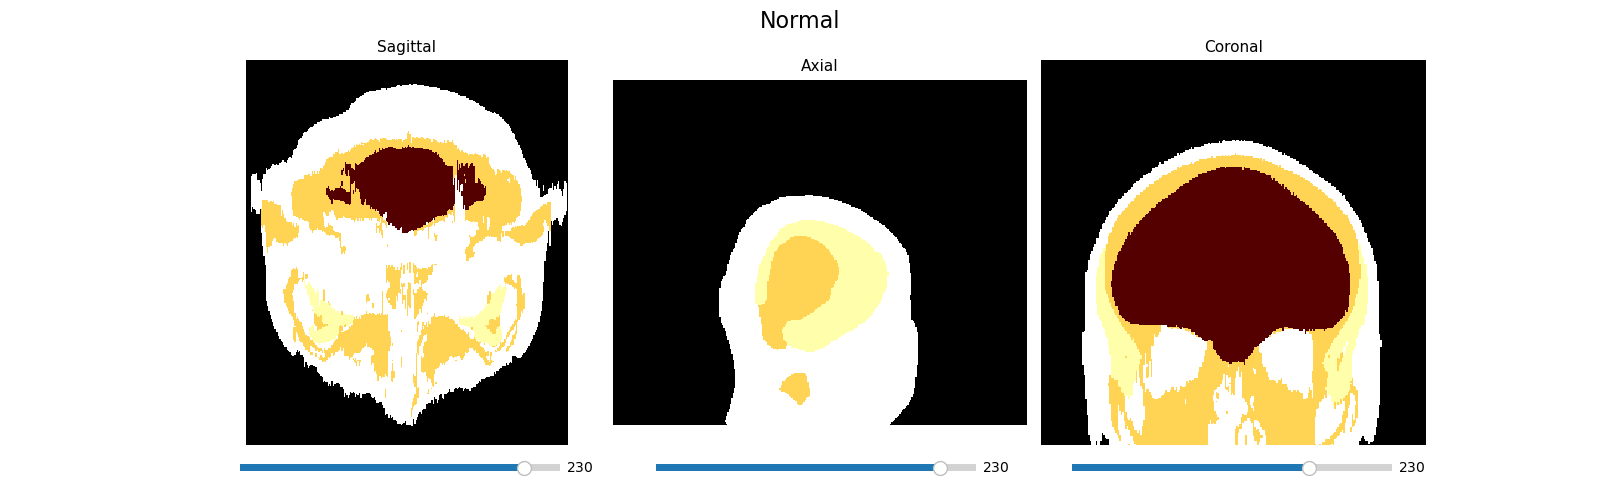

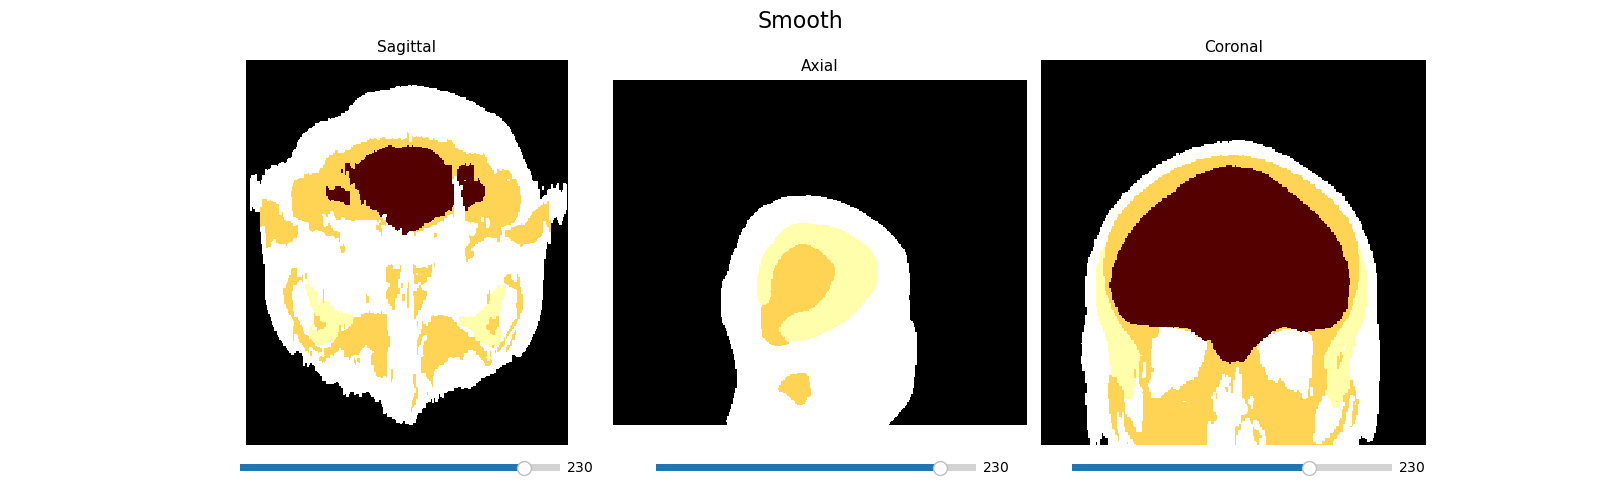

In [2]:
%matplotlib widget
nii_img = nib.load(mask_path)
nii_data = nii_img.get_fdata()

# median filter
# smooth_nii = ndimage.median_filter(nii_data, size=2)

manual_mask_dilat = ndimage.grey_dilation(nii_data, size=(1,1,2))
manual_mask_erod = ndimage.grey_erosion(manual_mask_dilat, size=(1,3,1))

disp.displayMRIplot(nii_data, 230, slider = True, title = 'Normal')
disp.displayMRIplot(manual_mask_erod, 230, slider = True, title = 'Smooth')

# disp.compareThree(nii_data, 'Mask source', smooth_nii, 'Mask with median filter', blur_nii, 'Mask with gaussian blur')


In [3]:
nib.save(nib.Nifti1Image(manual_mask_erod, nii_img.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Manual segmentation/Smooth_Mask_v5.nii.gz")

#### **5ttgen mask process**

In [2]:
# Files

%matplotlib widget
T1_nii = nib.load("/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1w_acpc_dc_restore.nii.gz")
T1_data = T1_nii.get_fdata()

ttgen_nii = nib.load("/user/lcorcos/home/Desktop/MRI_Project/Data/Fast/101006/T1w/T1w_acpc_dc_restore.nii.gz")
ttgen_data = ttgen_nii.get_fdata()

GM_data = ttgen_data[:,:,:,0]
Core_data = ttgen_data[:,:,:,1]
WM_data = ttgen_data[:,:,:,2]
CSF_data = ttgen_data[:,:,:,3]

# disp.displayMRIplot(GM_data, 120, slider = True, title = 'Normal')

#### Grey matter preprocess

In [3]:
%matplotlib widget

GM_erod = ndimage.grey_erosion(GM_data, size=(2,1,2))
Gm_dilat = ndimage.grey_dilation(GM_erod, size=(1,1,1))
smooth_GM_data = ndimage.median_filter(Gm_dilat, size=2)
smooth_GM_data_thres = np.where(smooth_GM_data >= 0.15, smooth_GM_data, 0)

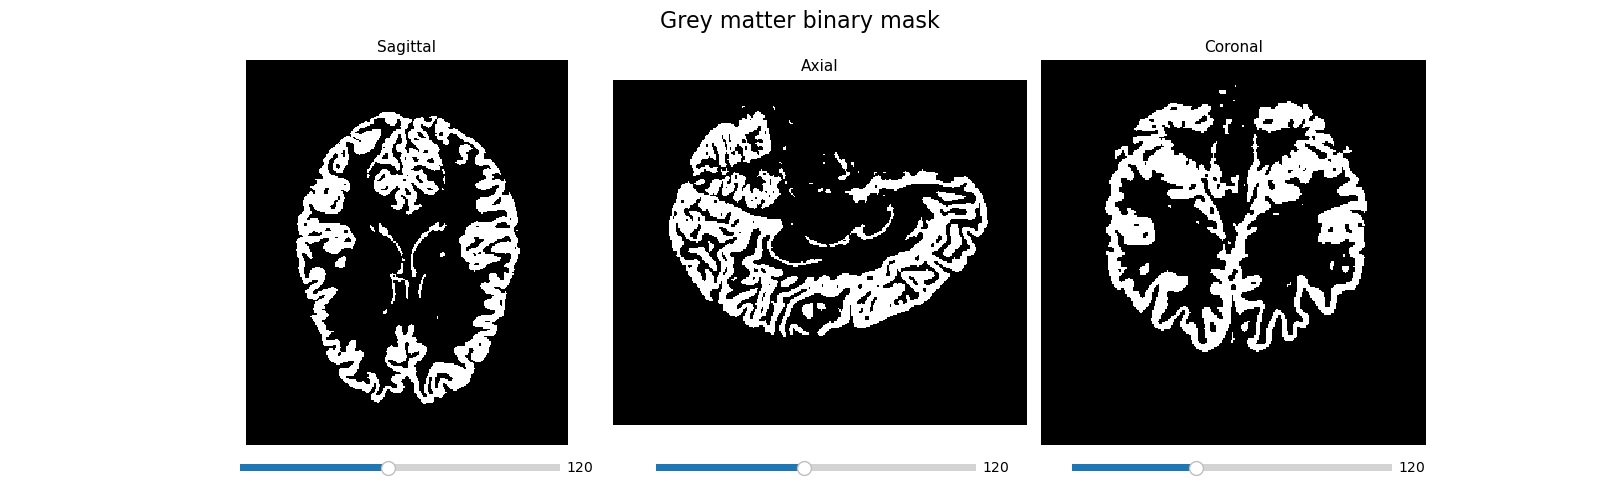

In [4]:
GM_mask = cv2.threshold(smooth_GM_data_thres, 0, 1, cv2.THRESH_BINARY)
GM_mask = GM_mask[1]
disp.displayMRIplot(GM_mask, 120, slider = True, title = 'Grey matter binary mask')

In [5]:

nib.save(nib.Nifti1Image(GM_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_GM.nii.gz")

#### Core preprocess

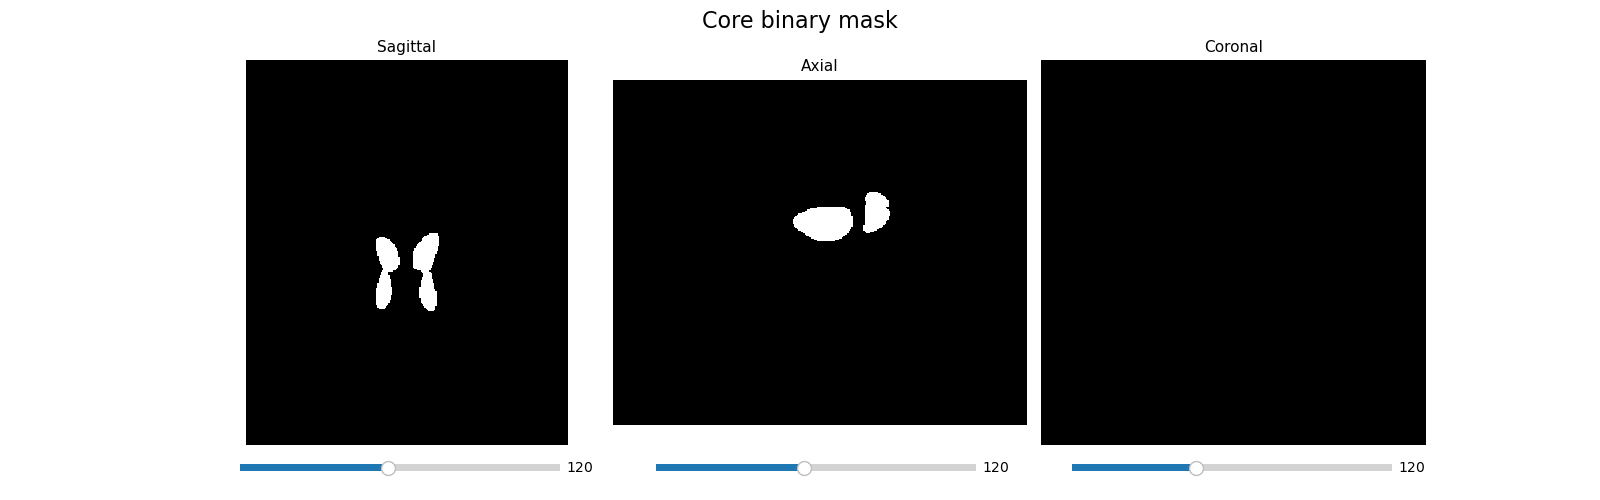

In [6]:
Core_mask = cv2.threshold(Core_data, 0, 1, cv2.THRESH_BINARY)
Core_mask = Core_mask[1]
disp.displayMRIplot(Core_mask, 120, slider = True, title = 'Core binary mask')

In [7]:

nib.save(nib.Nifti1Image(Core_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_Core.nii.gz")

#### White matter preprocess

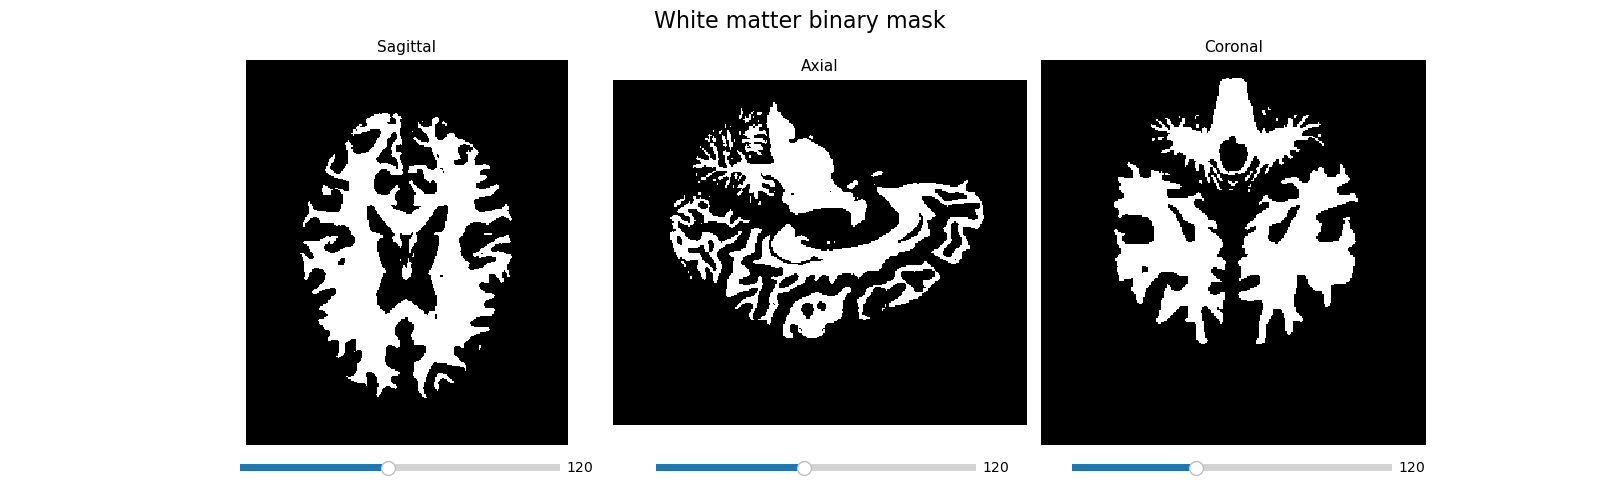

In [8]:
%matplotlib widget

WM_erod = ndimage.grey_erosion(WM_data, size=(1,2,1), mode='nearest')
WM_dilat = ndimage.grey_dilation(WM_erod, size=(1,2,1), mode='nearest')

smooth_WM_data = ndimage.median_filter(WM_dilat, size=2)

smooth_WM_data_thres = np.where(smooth_WM_data >= 0.6, smooth_WM_data, 0)

WM_mask = cv2.threshold(smooth_WM_data_thres, 0, 1, cv2.THRESH_BINARY)
WM_mask = WM_mask[1]

disp.displayMRIplot(WM_mask, 120, slider = True, title = 'White matter binary mask')

In [9]:

nib.save(nib.Nifti1Image(WM_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_WM.nii.gz")

#### CSF preprocess

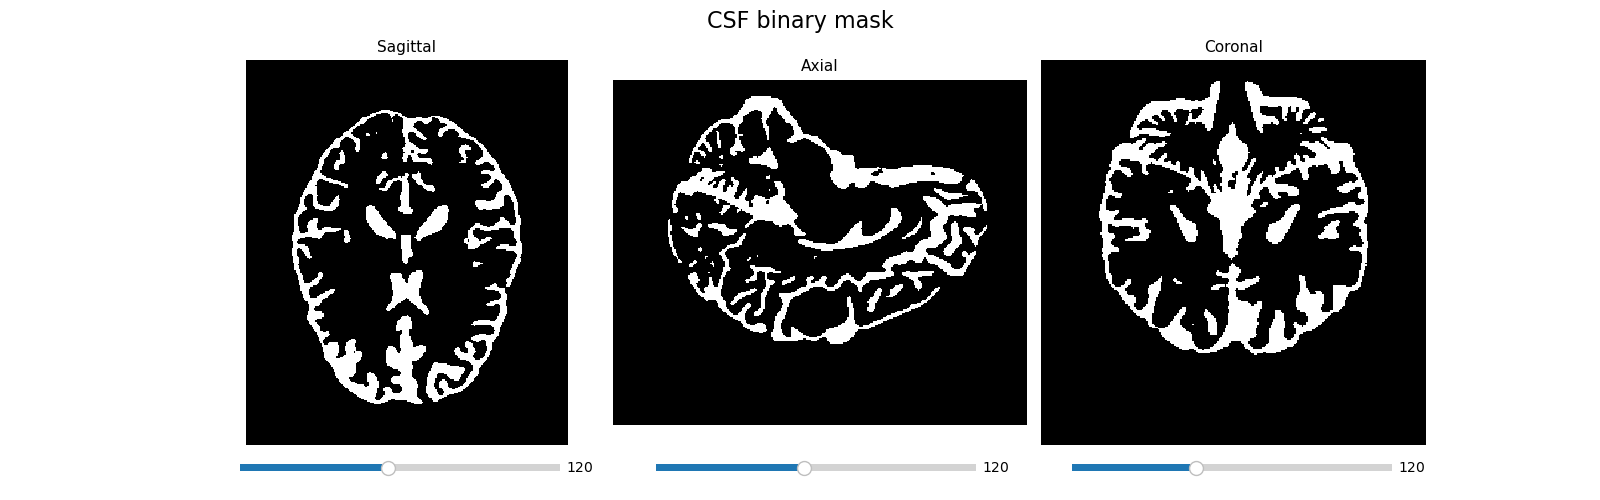

In [10]:
%matplotlib widget

CSF_dilat = ndimage.grey_dilation(CSF_data, size=(1,3,3), mode='nearest')
CSF_erod = ndimage.grey_erosion(CSF_dilat, size=(1,2,2), mode='nearest')

smooth_CSF_data = ndimage.median_filter(CSF_erod, size=3)

smooth_CSF_data_thres = np.where(smooth_CSF_data >= 0.3, smooth_CSF_data, 0)

CSF_mask = cv2.threshold(smooth_CSF_data_thres, 0, 1, cv2.THRESH_BINARY)
CSF_mask = CSF_mask[1]

disp.displayMRIplot(CSF_mask, 120, slider = True, title = 'CSF binary mask')

In [11]:

nib.save(nib.Nifti1Image(CSF_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_CSF.nii.gz")

#### Merges masks

In [12]:
Core_mask_new = Core_mask - WM_mask
Core_mask_new[Core_mask_new<0] = 0
nib.save(nib.Nifti1Image(Core_mask_new, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_Core.nii.gz")

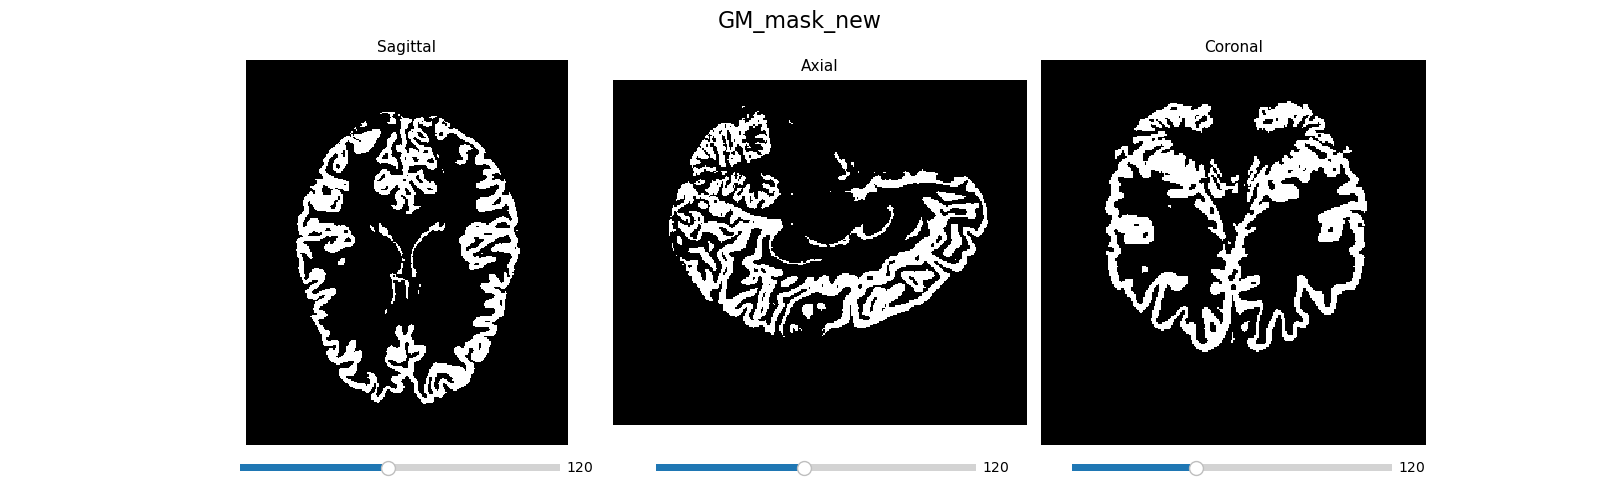

In [13]:
GM_mask_new = GM_mask - WM_mask - Core_mask_new
GM_mask_new[GM_mask_new<0] = 0
disp.displayMRIplot(GM_mask_new, 120, slider = True, title = 'GM_mask_new')

In [14]:
nib.save(nib.Nifti1Image(GM_mask_new, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_GM-VM.nii.gz")

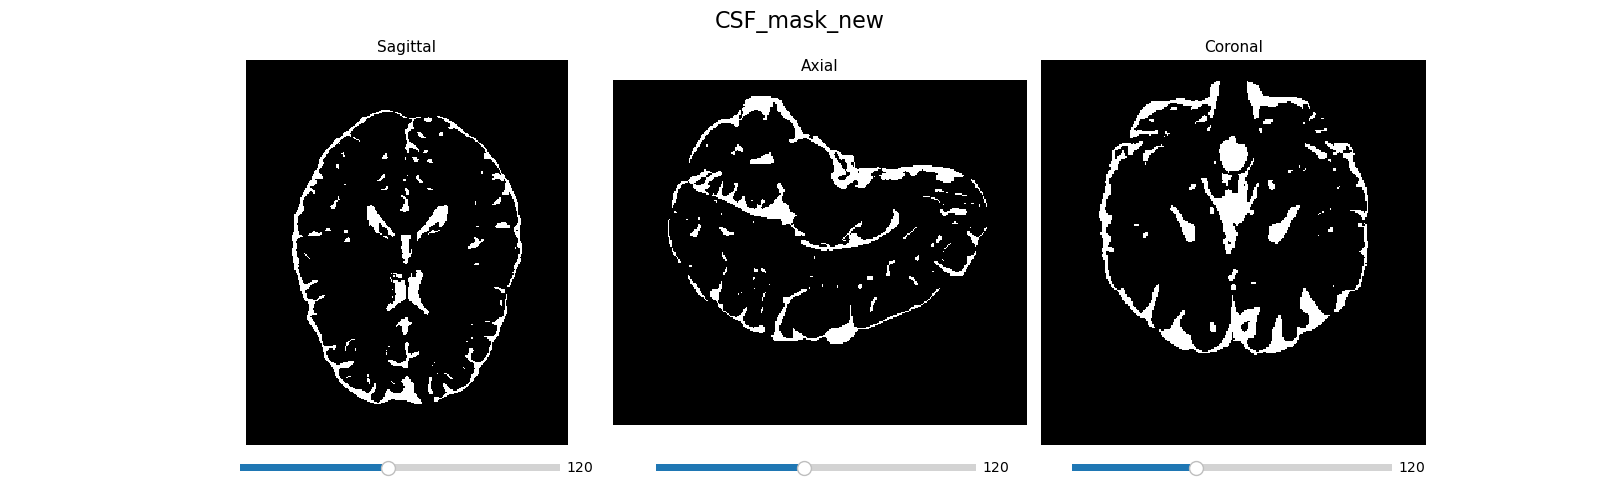

In [15]:
CSF_mask_new = CSF_mask - GM_mask_new - WM_mask - Core_mask_new
CSF_mask_new[CSF_mask_new<0] = 0
disp.displayMRIplot(CSF_mask_new, 120, slider = True, title = 'CSF_mask_new')

In [16]:
nib.save(nib.Nifti1Image(CSF_mask_new, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/T1_CSF-GM-WM.nii.gz")

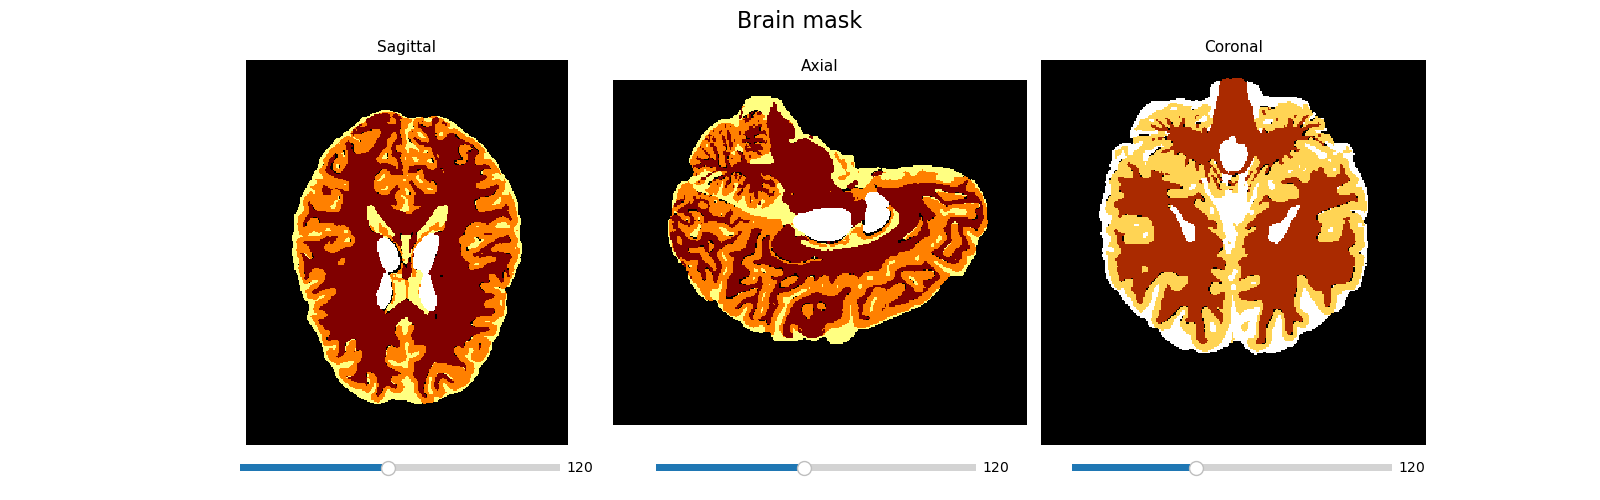

In [62]:
data_shape = ttgen_data.shape
brain_mask = np.zeros((data_shape[0], data_shape[1], data_shape[2]))

brain_mask = brain_mask + WM_mask + 2*GM_mask_new + 3*CSF_mask_new + 4*Core_mask_new

disp.displayMRIplot(brain_mask, 120, slider = True, title = 'Brain mask')

In [63]:
nib.save(nib.Nifti1Image(brain_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/brain_mask.nii.gz")

File:  [██████████████████████████████████████████████████████████████████████] 260 / 260


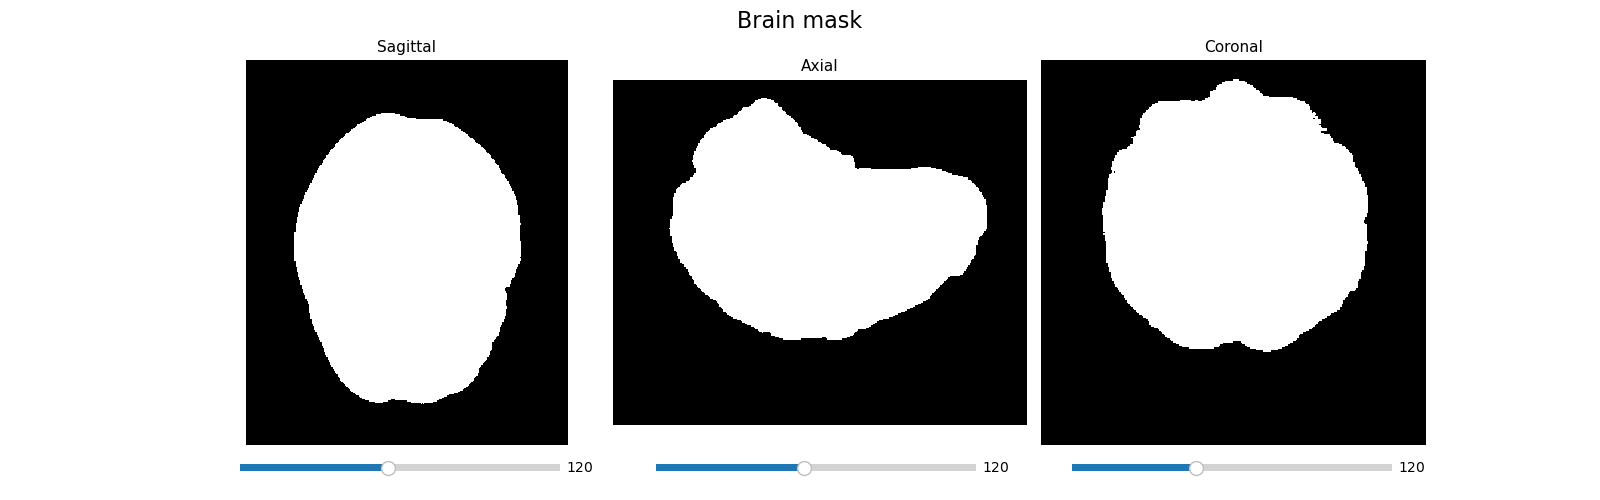

In [53]:
import skimage
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage import segmentation

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)

    def show(j):
        x = int(size*j/count)
        file.write("{}[{}{}] {} / {}\r".format(prefix,
                                               "█"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.flush()
    file.write("\n")

def sobel2D(image):
    sx = ndi.sobel(image, axis=0, mode='reflect')
    sy = ndi.sobel(image, axis=1, mode='reflect')
    sob = np.hypot(sx, sy)
    return sob


def removeBackground(image, file_name):
    size = len(image)
    
    brain_mask = np.zeros((image.shape[0], image.shape[1], image.shape[2]))

    for i in progressbar(range(size), "File: " + file_name + " ", 70):

        img = image[i]

        elevation_map = sobel2D(img)

        markers = np.zeros_like(img)
        markers[img < 1] = 1
        markers[img >= 1] = 2

        segmentation_base = segmentation.watershed(
            elevation_map, markers, watershed_line=True, offset=(3,3))

        segmentation_final = ndi.binary_fill_holes(
            segmentation_base - 1)

        mask, _ = ndi.label(segmentation_final)
        # img[mask == 0] = 0

        brain_mask[i] = mask

    return brain_mask

# ─── MAIN SCRIPT ────────────────────────────────────────────────────────────────

result_ndarray = removeBackground(brain_mask, "")
result_ndarray_mask = cv2.threshold(result_ndarray, 0, 1, cv2.THRESH_BINARY)
result_ndarray_mask = result_ndarray_mask[1]
nib.save(nib.Nifti1Image(result_ndarray_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/mask.nii.gz")

disp.displayMRIplot(result_ndarray_mask, 120, slider = True, title = 'Brain mask')

In [64]:
brain_mask_filled = np.ndarray.copy(brain_mask)
nib.save(nib.Nifti1Image(brain_mask, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/mask_copy.nii.gz")

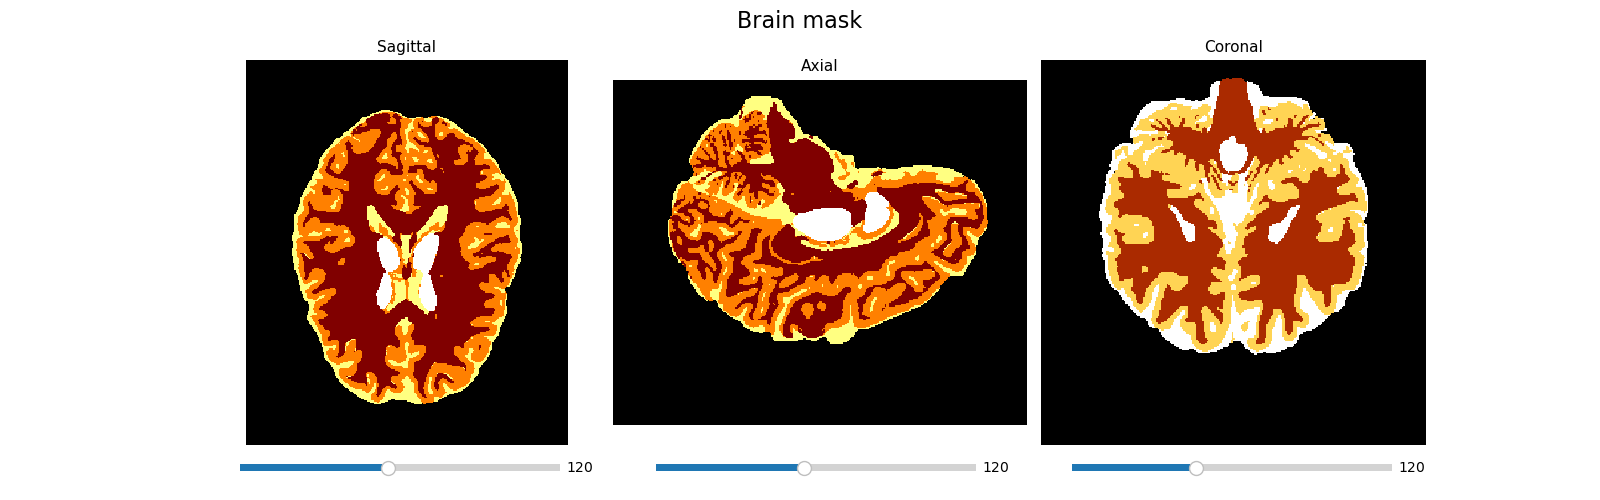

In [65]:
brain_mask_filled = np.ndarray.copy(brain_mask)
for i in range(0,data_shape[0]):
    for j in range(0, data_shape[1]):
        for k in range(0, data_shape[2]):
            if (result_ndarray_mask[i,j,k] == 1 and brain_mask_filled[i,j,k] == 0):
                brain_mask_filled[i,j,k] = 2

disp.displayMRIplot(brain_mask_filled, 120, slider = True, title = 'Brain mask')

In [66]:
nib.save(nib.Nifti1Image(brain_mask_filled, ttgen_nii.affine), "/user/lcorcos/home/Desktop/MRI_Project/Data/Best_Color/101006/T1w/mask_filled.nii.gz")